In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

from network.network import RNNModel
from utils import make_train_data, TrajectoryGenerator, create_ratemaps, plot_ratemaps
%load_ext autoreload
%autoreload 2

### Load data

In [2]:
position, velocity, head_dir = torch.load('models/data.pt')
data = make_train_data(velocity.reshape(1, -1), head_dir.reshape(1, -1))

In [37]:
# load model
hidden_size = 256
mini_batch_size = 32
rnn_layer = 'custom'
rnn_model = torch.load(f'models/RNN-{hidden_size}-{rnn_layer}-model.pt')

rnn_model.eval()
aggregate_loss, y, x, u = rnn_model.evaluate(data, position)

# Only get the first entries because we only have a single trajectory to evaluate
y = y[0]
x = x[0]
u = u[0]

Start evaluation run: 


Aggregated loss: 0.0008323814071082522  0.953 seconds for this run 



### Plot trajectories

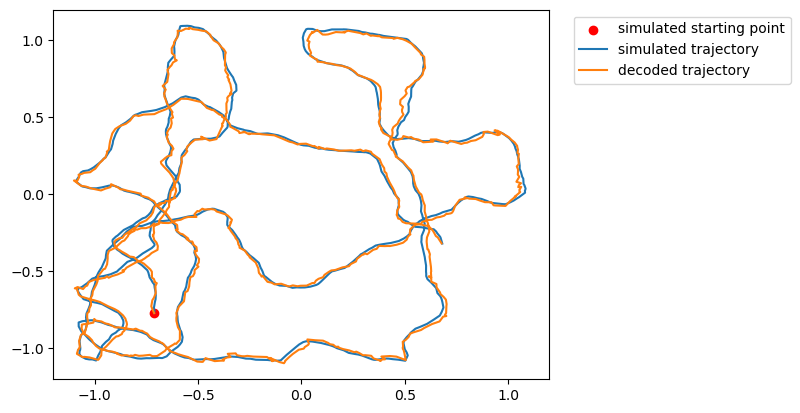

In [38]:
# plot trajectories generated from the network (on test data)
plt.scatter(position[0, 0], position[0, 1], color = 'red', label = 'simulated starting point')
plt.plot(position[:, 0], position[:, 1], label = 'simulated trajectory')

y[0, :] = position[0, :]
plt.plot(y[:, 0], y[:, 1], label = 'decoded trajectory')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend(bbox_to_anchor=(1.5, 1.))

plt.savefig('trajectory.png', bbox_inches='tight')
# plt.show()

### Compute spatial maps

In [39]:
box_width = 2.2
box_height = 2.2
resolution = 0.2 # bin size in (m)

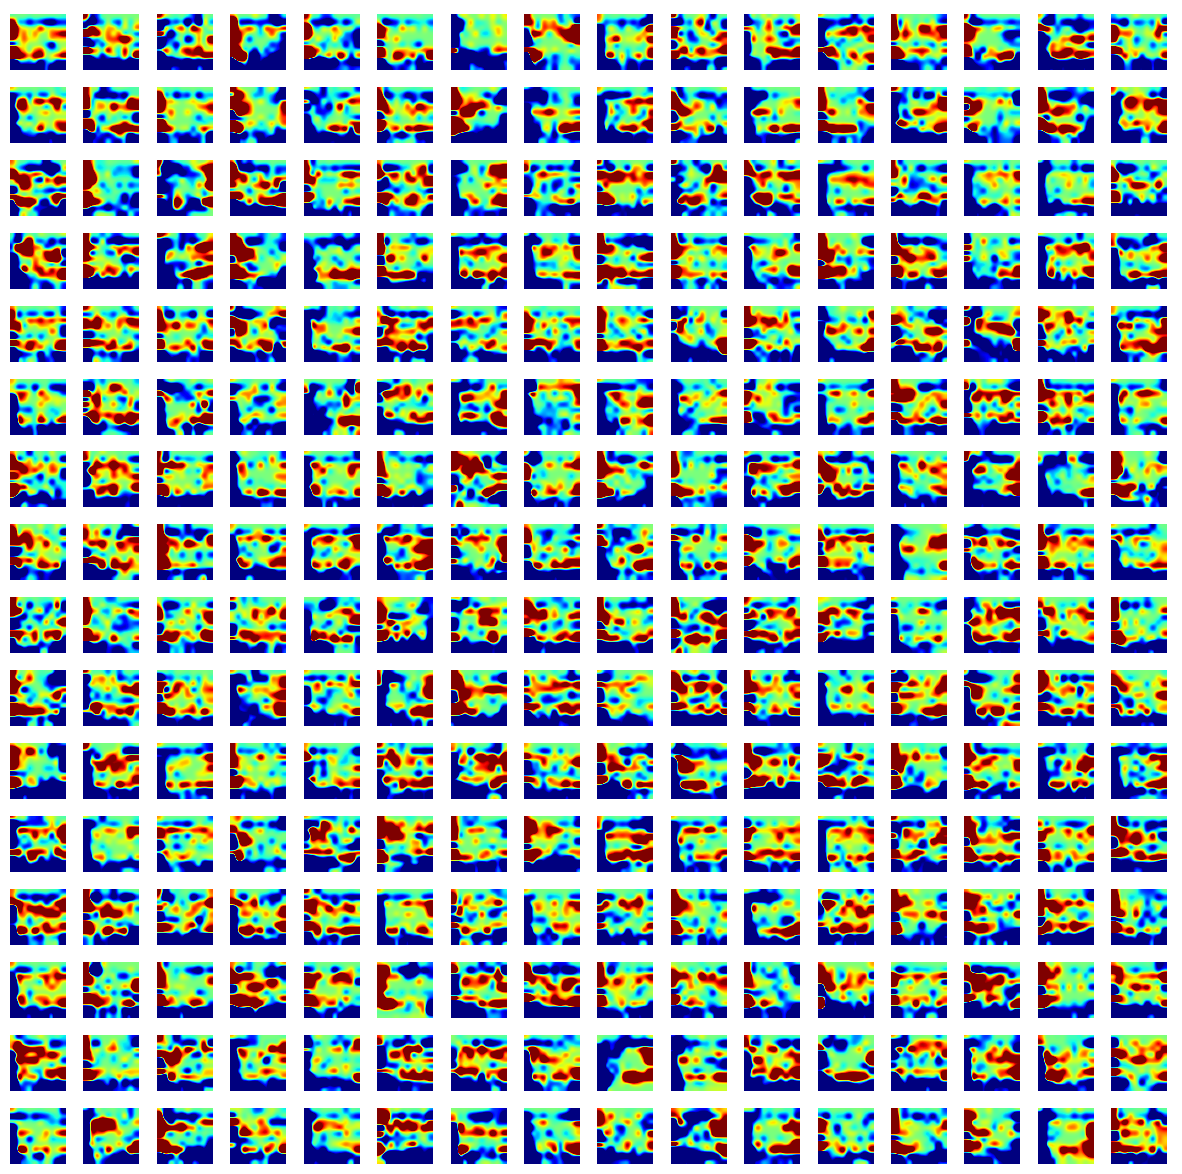

In [40]:
spatial_maps = create_ratemaps(u, y, box_width=box_width, box_height=box_height)
plot_ratemaps(spatial_maps, hidden_size, box_width, box_height, resolution, True)